## Perform linear regression on experimental data to continuously approximate how cell compositions change with growth rate. 

### Gather experimental values of ribosomes, ternary complexes, cell mass, and cell volume as a function of growth rate from literature.

In [12]:
import numpy as np
import matplotlib.pyplot as plt


#Active Ribosomes
x_rib = np.array([0.6,1.0,1.5,2.0,2.5,3.0])
y_rib = np.array([8000,15000,26000,44000,61000,73000])
y_rib = np.array([int(y_i*0.85) for y_i in y_rib])

#Ternary complexes
x_tern = np.array([0.4,0.7,1.07,1.6,2.5,3.0]+[0.4]*5)
y_tern = np.array([48000,57000,83000,143000,323000,383000]+[48000]*5)

#Cell mass
x_mass = np.array([0.6,1.0,1.5,2.0,2.5,3.0])
y_mass = np.array([159,257,370,512,607,636])

## Cell Volume
x_vol = np.array([0.25,0.42,0.56,0.58,0.68,0.71,0.87,1.81,1.85,2.15,2.3])
y_vol = np.array([1.14,1.44,1.74,1.26,1.11,1.38,1.44,2.15,2.34,2.46,2.4])

##Nucleoid volume
x_nuc = np.array([0.4,1.36,2.85])
y_nuc = np.array([0.17,0.13,0.11])

x_vals = np.array([x_rib, x_tern, x_mass, x_vol,x_nuc])
y_vals = np.array([y_rib, y_tern, y_mass, y_vol,y_nuc])
label_vals = np.array(["Ribosomes", "Ternary complexes", "Cell mass", "Cell volume","Nucleoid volume"])

### Perform bootstrapping of different polynomial fits (i.e., 0th order, 1st order, and 2nd order polynomial) to find the best order polynomial to fit each experimental dataset (i.e., the lowest-complexity model that can best predict experimental data)

In [2]:
def bootstrap(x,y,order):
    MAE_tot=0
    B=10000
    for i in range(B):
        boot_indices = np.random.choice(np.arange(len(x)),len(x))
        
        if(len(np.unique(np.take(x,boot_indices)))>order):
            y_model = np.polyfit(np.take(x, boot_indices),np.take(y,boot_indices),order)
            for i,x_i in enumerate(x):
                y_i_hat = np.polyval(y_model,x_i)
                MAE_boot = np.abs(y[i] - y_i_hat)
                MAE_tot += MAE_boot
                
    MAE_avg = MAE_tot/B-1
    return MAE_avg

np.random.seed(1)
for i in range(len(x_vals)):
    print("\n",label[i])
    bootstrap_scores = list()
    poly_powers = [0,1,2]
    
    #Try fitting 0th, 1st, and 2nd order polynomials
    for order in poly_powers:
        #If there are more data than the order of polynomial being fit, then try that order
        if(len(x_vals[i])-1>order):
            bootstrap_scores.append(bootstrap(x_vals[i],y_vals[i],order))
    print("Boostrap MAE: ", ['{:.2e}'.format(score) for score in bootstrap_scores], ", Min order: ", np.argmin(bootstrap_scores))


 Ribosomes
Boostrap MAE:  ['1.13e+05', '1.25e+04', '1.31e+04'] , Min order:  1

 Ternary complexes
Boostrap MAE:  ['1.02e+06', '2.22e+05', '8.01e+04'] , Min order:  2

 Cell mass
Boostrap MAE:  ['9.96e+02', '1.61e+02', '1.26e+02'] , Min order:  2

 Cell volume
Boostrap MAE:  ['4.14e+00', '6.56e-01', '1.09e+00'] , Min order:  1

 Nucleoid volume
Boostrap MAE:  ['-9.28e-01', '-9.76e-01'] , Min order:  1


### Fit polynomials to data and calculate R^2 values

[0.99, 0.99, 0.99, 0.87, 0.9]


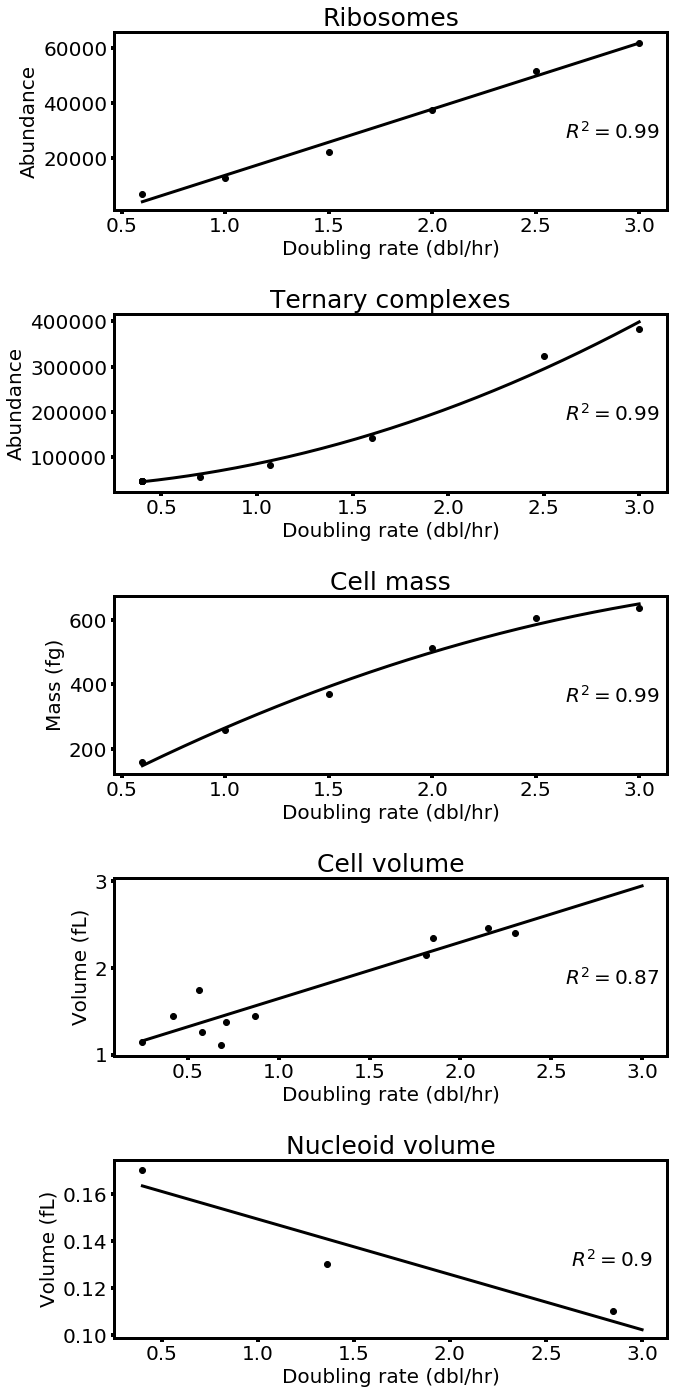

In [131]:
#Calculation of polynomial fits are in analysis_parameters.py
from analysis_parameters import *
from sympy import S, symbols, expand, Symbol
import sympy

def calc_R2(x,y,y_hat):
    SS_tot = np.sum((y-np.average(y))**2) #Sum of squares total (proportional to variance; n times larger than variance)
    SS_err = np.sum((y-y_hat)**2) # Sum of squared errors
    return 1-SS_err/SS_tot

dbl_rate_list = list()
for i in range(len(x_labels)):
    dbl_rate_list.append(np.arange(min(x_vals[i]),3.01,0.01))

ribs = [f_rib(i) for i in dbl_rate_list[0]]
tern = [f_tern(i) for i in dbl_rate_list[1]]
mass = [f_mass(i) for i in dbl_rate_list[2]]
vol = [f_vol(i) for i in dbl_rate_list[3]]
nuc = [f_nuc(i) for i in dbl_rate_list[4]]

fig,ax = plt.subplots(5,1,figsize=(10,20))

y_labels = ['Abundance','Abundance','Mass (fg)','Volume (fL)', 'Volume (fL)']
y_fits = [ribs,tern,mass,vol,nuc]
fits = [lambda x:f_rib(x),lambda x:f_tern(x),lambda x:f_mass(x),lambda x:f_vol(x), lambda x:f_nuc(x)]
R2_arr = list()

for i in range(len(y_vals)):
    R2_arr.append(np.around(calc_R2(x_vals[i],y_vals[i],fits[i](x_vals[i])),2))
    
    ax[i].plot(dbl_rate_list[i],y_fits[i],color='black',linewidth=3)
    ax[i].scatter(x_vals[i],y_vals[i],color='black')
    
    ax[i].spines['left'].set_linewidth(3)
    ax[i].spines['bottom'].set_linewidth(3)
    ax[i].spines['top'].set_linewidth(3)
    ax[i].spines['right'].set_linewidth(3)
    ax[i].set_ylabel(x_labels[i],size=20)
    ax[i].set_xlabel('Doubling rate (dbl/hr)',size=20)
    ax[i].tick_params(axis='both', which='major',width=4, labelsize=20)
    ax[i].set_title(label_vals[i],fontsize=25)
    ax[i].text(0.9,0.4,r'$R^2=$'+str(R2_arr[-1]),horizontalalignment='center',transform=ax[i].transAxes,fontsize=20)

plt.tight_layout(pad=3.0)
print(R2_arr)

### Plot 1) number of crowders per cell vs. growth rate, and 2) abundances of ternary complexes, ribosomes, and crowders in a translation voxel across growth rate. Do so by instantiating cell/voxel parametrization class.

Text(0.5, 1.0, 'Crowders')

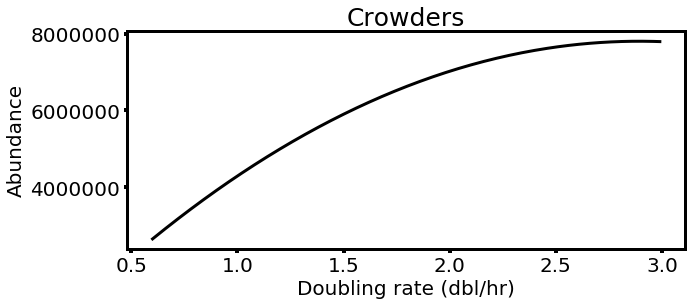

In [180]:

#Also need to fill out references for table based on existing text

dbl_rate=np.arange(0.6,3.0,0.01)
crowderAbundance = list()
for i in range(len(dbl_rate)):
    cell_volfrac_tot = list()
    cellParams, voxelParams = calcParams(f_rib(dbl_rate[i]),
                                               f_tern(dbl_rate[i]),
                                               f_mass(dbl_rate[i]),
                                               f_vol(dbl_rate[i]),
                                               f_nuc(dbl_rate[i]))
    crowderAbundance.append(cellParams[2][2])

fig,ax = plt.subplots(1,1,figsize=(10,4))
ax.plot(dbl_rate,crowderAbundance,color='black',linewidth=3)
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
ax.set_ylabel('Abundance',size=20)
ax.set_xlabel('Doubling rate (dbl/hr)',size=20)
ax.tick_params(axis='both', which='major',width=4, labelsize=20)
ax.set_title('Crowders',fontsize=25)

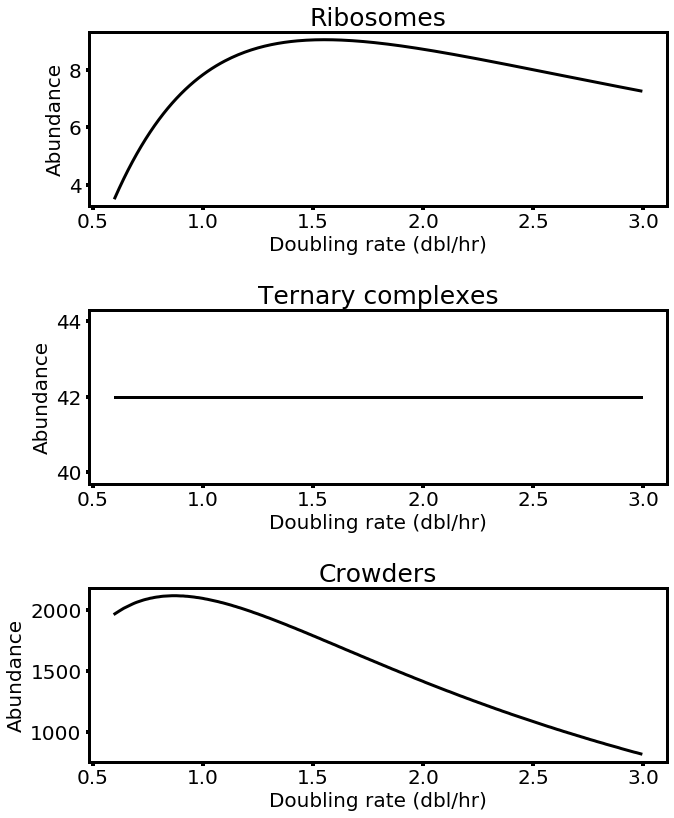

In [130]:
dbl_rate=np.arange(0.6,3.0,0.01)
ribAbundance_vox = list()
ternAbundance_vox = list()
crowderAbundance_vox = list()

for i in range(len(dbl_rate)):
    cell_volfrac_tot = list()
    cellParams, voxelParams = calcParams(f_rib(dbl_rate[i]),
                                               f_tern(dbl_rate[i]),
                                               f_mass(dbl_rate[i]),
                                               f_vol(dbl_rate[i]),
                                               f_nuc(dbl_rate[i]))
    ribAbundance_vox.append(voxelParams[2][0])
    ternAbundance_vox.append(voxelParams[2][1])
    crowderAbundance_vox.append(voxelParams[2][2])

fig,ax = plt.subplots(3,1,figsize=(10,12))
abundances = [ribAbundance_vox,ternAbundance_vox, crowderAbundance_vox]
labels = ['Ribosomes','Ternary complexes', 'Crowders']

for i,count in enumerate(abundances):
    ax[i].plot(dbl_rate,count,color='black',linewidth=3)
    ax[i].spines['left'].set_linewidth(3)
    ax[i].spines['bottom'].set_linewidth(3)
    ax[i].spines['top'].set_linewidth(3)
    ax[i].spines['right'].set_linewidth(3)
    ax[i].set_ylabel('Abundance',size=20)
    ax[i].set_xlabel('Doubling rate (dbl/hr)',size=20)
    ax[i].tick_params(axis='both', which='major',width=4, labelsize=20)
    ax[i].set_title(labels[i],fontsize=25)
plt.tight_layout(pad=3.0)

In [181]:
dbl_rate=np.array([0.6,1.0,1.5,2.0,2.5,3.0])
crowderAbundance = list()
for i in range(len(dbl_rate)):
    cell_volfrac_tot = list()
    cellParams, voxelParams = calcParams(f_rib(dbl_rate[i]),
                                               f_tern(dbl_rate[i]),
                                               f_mass(dbl_rate[i]),
                                               f_vol(dbl_rate[i]),
                                               f_nuc(dbl_rate[i]))
    crowderAbundance.append(cellParams[2][2])
print(crowderAbundance)

[2658730.1227096315, 4295636.280548278, 5901954.9124240745, 7019591.249385975, 7648545.291433977, 7788817.038568074]
